In [1]:
# Import necessary libraries
import pandas as pd
from collections import defaultdict
import os
from general_used_functions import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor


config_data = load_config_file()

# Load training data
DATA_DIR = os.getcwd() + '/data'
training_stock_df = defaultdict(list)
stock_list = config_data['stock_dict'].keys()

for stock in stock_list:
    feature_data = pd.read_excel(f'{DATA_DIR}/training_data_full/training_feature_{stock}.xlsx')
    stock_data = pd.read_excel(f'{DATA_DIR}/stock_price_data/training/{stock}_stock_price_data(training).xlsx')

    # Merge the two dataframes on 'date'
    merged_data = pd.merge(feature_data, stock_data, on='date', how='left')

    # Drop the 'date' column from the feature data
    merged_data.drop(columns=['date'], inplace=True)

    # Store the merged data in the dictionary
    training_stock_df[stock] = merged_data


In [2]:
# Create a counter to count the features selected by different methods
feature_counter = defaultdict(list)
for stock in stock_list:
    feature_counter[stock] = {}
    for feature in training_stock_df[stock].columns:
        if feature == stock:
            continue
        feature_counter[stock][feature] = 0

### Method 1: Pearson correlation coefficient 

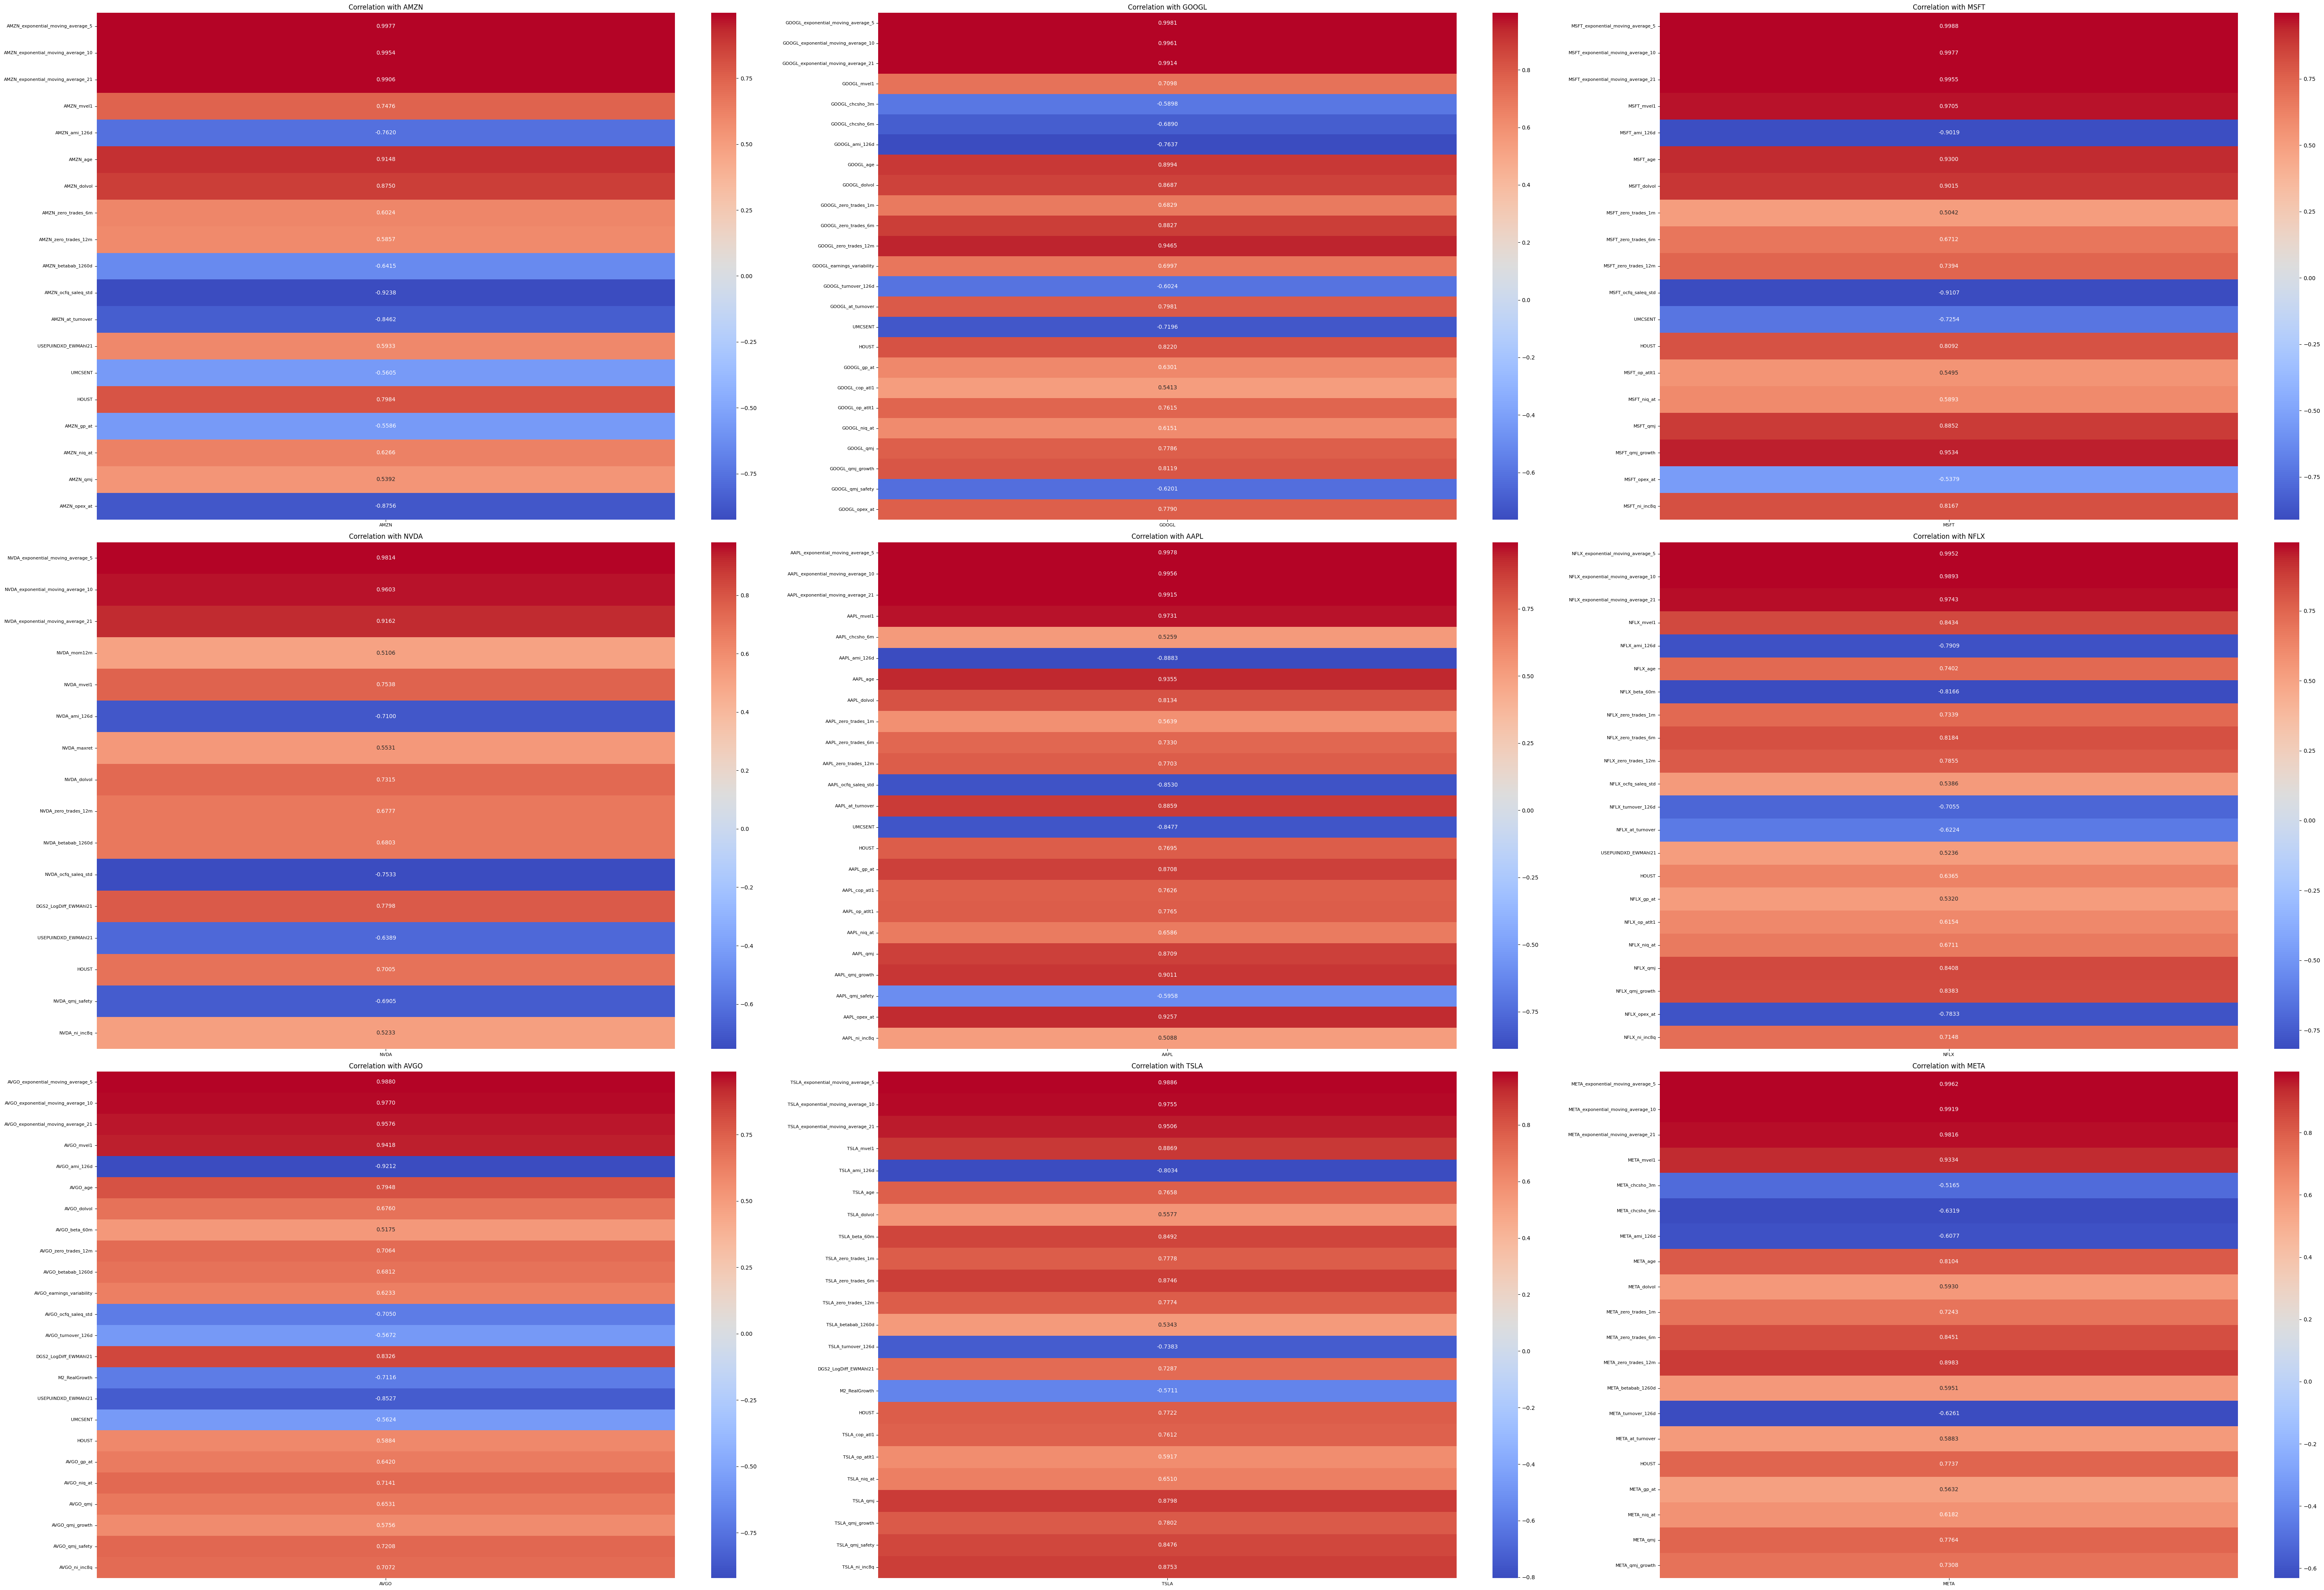

In [3]:
def plot_corr_matrix_with_specific_column(data_df, column_name, ax):
    CorrMatrix = data_df.corr()
    column_corr = CorrMatrix[[f"{column_name}"]]

    # Apply the threshold filter so that correlations not above 0.5 or below -0.5 become NaN
    column_corr = column_corr.where((column_corr >= 0.5) | (column_corr <= -0.5))

    # Exclude self-correlation
    column_corr = column_corr.drop(index=column_name)

    # Remove rows that became all NaN after filtering
    column_corr = column_corr.dropna(how='all')

    sns.heatmap(column_corr, annot=True, fmt='.4f', cmap='coolwarm', cbar=True, ax=ax)
    ax.set_title(f'Correlation with {column_name}', fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

    return column_corr.index

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(60, 40))
axes = axes.flatten()

for i, (key, value) in enumerate(training_stock_df.items()):
    if i < len(axes):
        stock = key.split("_")[0]
        selected_feature = plot_corr_matrix_with_specific_column(value, stock, axes[i])

        # Store the selected features in the feature_counter
        for feature in selected_feature:
            feature_counter[stock][feature] += 1

plt.tight_layout()
plt.show()

### Method 2: Recursive Feature Elimination (RFE)

In [4]:
for stock in stock_list:
    model = LinearRegression()
    rfe = RFE(model, n_features_to_select=24)
    fit = rfe.fit(training_stock_df[stock].drop(columns=[stock]), training_stock_df[stock][stock].values.ravel())
    selected_features_rfe = training_stock_df[stock].drop(columns=[stock]).columns[fit.support_]

    # Store the selected features in the feature_counter
    for feature in selected_features_rfe:
        feature_counter[stock][feature] += 1

    print(f"Stock: {stock}")
    print("Selected Features:", selected_features_rfe)
    print("--------------------------------------------------------")

Stock: AMZN
Selected Features: Index(['AMZN_sortino_ratio_5', 'AMZN_sortino_ratio_10',
       'AMZN_sortino_ratio_21', 'AMZN_mom1m', 'AMZN_rvol_21d',
       'AMZN_chcsho_1m', 'AMZN_chcsho_3m', 'AMZN_chcsho_6m', 'AMZN_ami_126d',
       'AMZN_maxret', 'AMZN_zero_trades_1m', 'AMZN_zero_trades_6m',
       'AMZN_zero_trades_12m', 'AMZN_ocfq_saleq_std', 'AMZN_turnover_126d',
       'AMZN_at_turnover', 'T_30', 'AMZN_VXN_LogDiff_EWMAhl63', 'CPI_ROC',
       'DGS2_LogDiff_EWMAhl21', 'AMZN_gp_at', 'AMZN_niq_at', 'AMZN_qmj',
       'AMZN_opex_at'],
      dtype='object')
--------------------------------------------------------
Stock: GOOGL
Selected Features: Index(['GOOGL_downside_deviation_5', 'GOOGL_downside_deviation_10',
       'GOOGL_downside_deviation_21', 'GOOGL_mom12m', 'GOOGL_mom1m',
       'GOOGL_rvol_21d', 'GOOGL_chcsho_1m', 'GOOGL_chcsho_6m',
       'GOOGL_ami_126d', 'GOOGL_zero_trades_1m', 'GOOGL_zero_trades_6m',
       'GOOGL_zero_trades_12m', 'GOOGL_ocfq_saleq_std', 'GOOGL_turnover_

### Method 3: Elastic Net Regularization

In [5]:
from sklearn.linear_model import ElasticNet

for stock in stock_list:
    model = ElasticNet(alpha=0.1, l1_ratio=0.7, random_state=42, max_iter=1000000)
    model.fit(training_stock_df[stock].drop(columns=[stock]), training_stock_df[stock][stock].values.ravel())
    selected_features_en = training_stock_df[stock].drop(columns=[stock]).columns[model.coef_ != 0]

    # Store the selected features in the feature_counter
    for feature in selected_features_en:
        feature_counter[stock][feature] += 1

    print(f"Stock: {stock}")
    print("Selected Features:", selected_features_en)
    print("--------------------------------------------------------")

Stock: AMZN
Selected Features: Index(['AMZN_exponential_moving_average_5',
       'AMZN_exponential_moving_average_10',
       'AMZN_exponential_moving_average_21', 'AMZN_sortino_ratio_5',
       'AMZN_sortino_ratio_10', 'AMZN_sortino_ratio_21', 'AMZN_dolvol',
       'M2_RealGrowth', 'USEPUINDXD_EWMAhl21', 'UMCSENT', 'HOUST'],
      dtype='object')
--------------------------------------------------------
Stock: GOOGL
Selected Features: Index(['GOOGL_exponential_moving_average_5',
       'GOOGL_exponential_moving_average_10',
       'GOOGL_exponential_moving_average_21', 'GOOGL_sortino_ratio_5',
       'GOOGL_sortino_ratio_10', 'GOOGL_sortino_ratio_21', 'GOOGL_age',
       'GOOGL_dolvol', 'M2_RealGrowth', 'USEPUINDXD_EWMAhl21', 'UMCSENT',
       'HOUST', 'GOOGL_ni_inc8q'],
      dtype='object')
--------------------------------------------------------
Stock: MSFT
Selected Features: Index(['MSFT_exponential_moving_average_5',
       'MSFT_exponential_moving_average_10',
       'MSFT_expon

### Method 4: XGBoost

In [6]:
from xgboost import XGBRegressor

for stock in stock_list:
    model = XGBRegressor(n_estimators=10000, random_state=42)
    X = training_stock_df[stock].drop(columns=[stock])
    y = training_stock_df[stock][stock].values.ravel()

    model.fit(X, y)
    importances = model.feature_importances_
    indices_xgb = np.argsort(importances)[::-1]

    # Only keep the top 24 features
    top_indices_xgb = indices_xgb[:24]

    for feature in top_indices_xgb:
        feature_name = X.columns[feature]
        feature_counter[stock][feature_name] += 1
    
    print(f"Stock: {stock}")
    print("Selected Features:", X.columns[top_indices_xgb])
    print("--------------------------------------------------------")
    

Stock: AMZN
Selected Features: Index(['AMZN_mvel1', 'AMZN_age', 'AMZN_exponential_moving_average_5', 'T_30',
       'AMZN_ami_126d', 'AMZN_turnover_126d', 'AMZN_prc_highprc_252d',
       'AMZN_resff3_6_1', 'AMZN_mom6m', 'AMZN_rvol_21d', 'AMZN_zero_trades_1m',
       'AMZN_sortino_ratio_10', 'AMZN_mom1m', 'T10Y2Y_EWMAhl10',
       'USEPUINDXD_EWMAhl21', 'AMZN_exponential_moving_average_10',
       'AMZN_downside_deviation_10', 'AMZN_at_turnover', 'AMZN_opex_at',
       'AMZN_qmj_safety', 'AMZN_dolvol', 'M2_RealGrowth',
       'AMZN_VXN_LogDiff_EWMAhl63', 'AMZN_maxret'],
      dtype='object')
--------------------------------------------------------
Stock: GOOGL
Selected Features: Index(['GOOGL_age', 'GOOGL_mvel1', 'GOOGL_ami_126d',
       'GOOGL_exponential_moving_average_10', 'GOOGL_zero_trades_12m',
       'GOOGL_exponential_moving_average_5', 'GOOGL_seas_1_1na',
       'GOOGL_downside_deviation_10', 'GOOGL_mom6m', 'T10Y2Y_EWMAhl10',
       'GOOGL_chcsho_1m', 'GOOGL_mom1m', 'GOOGL_VXN_

### Method 5: Random forest (RF)

In [7]:
for stock in stock_list:
    forest = RandomForestRegressor(n_estimators=10000)

    forest.fit(training_stock_df[stock].drop(columns=[stock]), training_stock_df[stock][stock].values.ravel())
    importances = forest.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Only include feature with indices less than 25, without modify the original data
    selected_features_rf = training_stock_df[stock].drop(columns=[stock]).columns[indices[:24]]

    # Store the selected features in the feature_counter
    for feature in selected_features_rf:
        feature_counter[stock][feature] += 1

    print(f"Stock: {stock}")
    print("Selected Features:", selected_features_rf)
    print("--------------------------------------------------------")

Stock: AMZN
Selected Features: Index(['AMZN_mvel1', 'AMZN_exponential_moving_average_5',
       'AMZN_exponential_moving_average_21',
       'AMZN_exponential_moving_average_10', 'T_30', 'AMZN_mom1m', 'AMZN_age',
       'AMZN_mom6m', 'T10Y2Y_EWMAhl10', 'AMZN_gp_at', 'AMZN_zero_trades_1m',
       'AMZN_prc_highprc_252d', 'USEPUINDXD_EWMAhl21', 'AMZN_resff3_6_1',
       'AMZN_VXN_LogDiff_EWMAhl63', 'DGS2_LogDiff_EWMAhl21', 'AMZN_dolvol',
       'AMZN_turnover_126d', 'AMZN_qmj', 'AMZN_chmom', 'AMZN_seas_1_1na',
       'AMZN_qmj_growth', 'AMZN_mom12m', 'AMZN_ocfq_saleq_std'],
      dtype='object')
--------------------------------------------------------
Stock: GOOGL
Selected Features: Index(['GOOGL_mvel1', 'GOOGL_ami_126d', 'GOOGL_exponential_moving_average_5',
       'GOOGL_exponential_moving_average_21',
       'GOOGL_exponential_moving_average_10', 'GOOGL_age',
       'GOOGL_zero_trades_12m', 'GOOGL_mom1m', 'T10Y2Y_EWMAhl10',
       'GOOGL_mom6m', 'GOOGL_mom12m', 'GOOGL_VXN_LogDiff_EWMA

### Create a heatmap to visualize the feature importance

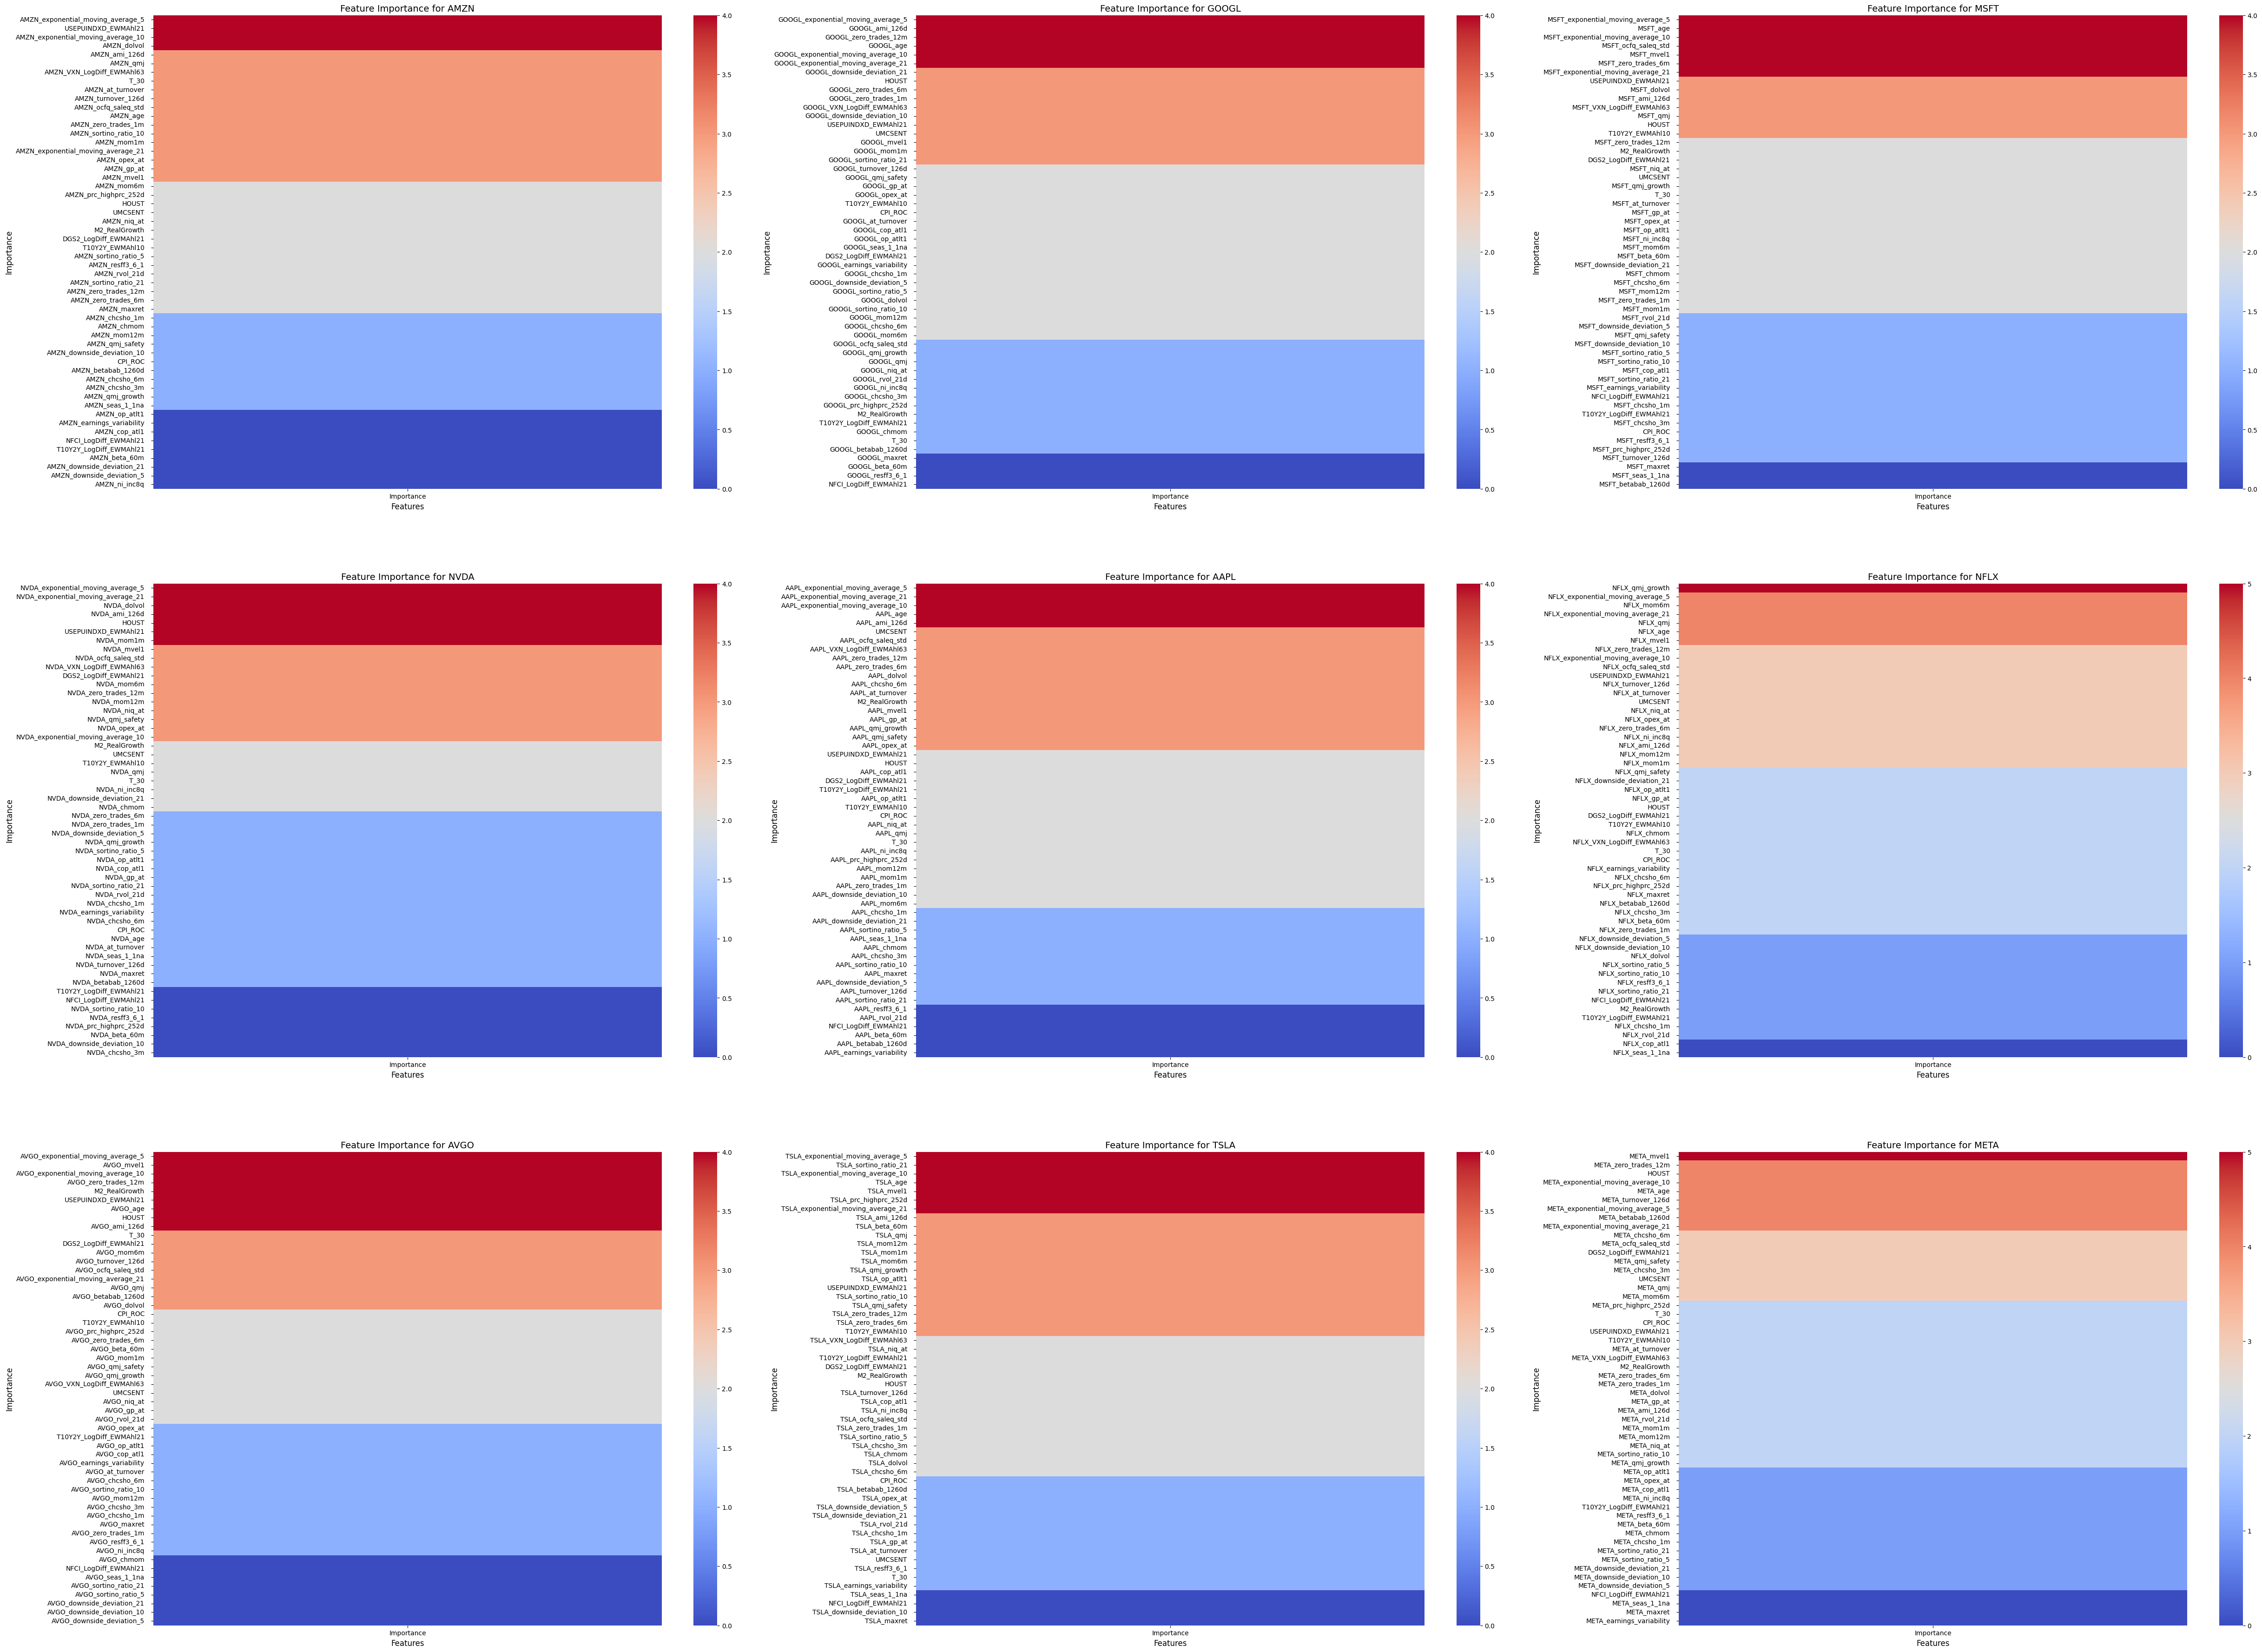

In [8]:
n_stocks = len(stock_list)
n_cols, n_rows = 3, 3

# Make the figure taller to allow more space for labels
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20*n_cols, 15*n_rows))
axes = axes.flatten()

# Plot the feature importance for each stock
for i, stock in enumerate(stock_list):
    feature_importance_df = pd.DataFrame(feature_counter[stock].items())
    feature_importance_df.columns = ['Feature', 'Importance']
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    hm = sns.heatmap(feature_importance_df.set_index('Feature')[['Importance']],
                     fmt="g", cmap="coolwarm", ax=axes[i], linewidths=0, yticklabels=True)
    axes[i].set_title(f"Feature Importance for {stock}", fontsize=14)
    axes[i].set_xlabel("Features", fontsize=12)
    axes[i].set_ylabel("Importance", fontsize=12)
    # Increase the y-tick label padding to separate them further
    axes[i].tick_params(axis='y', which='major', pad=10)

In [9]:
# Save the selected features with a json files, including the feature importance
for stock in stock_list:
    selected_features = [feature for feature, count in feature_counter[stock].items() if count > 0]
    with open(f'{DATA_DIR}/selected_feature/{stock}_selected_features.json', 'w') as f:
        json.dump(selected_features, f)